<a href="https://colab.research.google.com/github/manal-0603/Weather-Forecasting-using-Machine-Learning-algorithms/blob/main/ExtraTreeRegressor_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center><font style="color:rgb(100,109,254)">Weather Forecasting using Machine Learning algorithms</font> </center>**

<center>
<img src='https://www.analyticssteps.com/backend/media/thumbnail/6006173/6278986_1571298721_Weather_Forecoast_Graphics.jpg'></center>

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, HuberRegressor, Ridge, BayesianRidge, Lasso, LassoLars, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from sklearn.model_selection import TimeSeriesSplit
import missingno as msno
from scipy.stats import skew

In [ ]:
import pandas as pd

# Charger les dataset
donnnes_meteo = pd.read_csv('donnees_meteo.csv')

In [ ]:
# Assurez-vous que l'index est de type 'Timestamp'
donnnes_meteo.index = pd.to_datetime(donnnes_meteo["datetime"])

donnnes_meteo['year'] = pd.to_datetime(donnnes_meteo["datetime"]).dt.year

# Diviser les données en fonction de la date
train_data = donnnes_meteo[donnnes_meteo.index.year < 2020]  # Données d'entraînement jusqu'à 2019
val_data = donnnes_meteo[donnnes_meteo.index.year == 2020]   # Données de validation en 2020
test_data = donnnes_meteo[donnnes_meteo.index.year >= 2021]  # Données de test à partir de 2021

In [ ]:
selected_columns_train =['dew', 'humidity', 'precip',
       'precipprob', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'conditions_Clear',
       'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Fog', 'conditions_Rain, Overcast',
       'conditions_Rain, Partially cloudy']

X_train, y_train = train_data[selected_columns_train], train_data['temp']
X_test, y_test = test_data[selected_columns_train], test_data['temp']
X_val, y_val = val_data[selected_columns_train], val_data['temp']

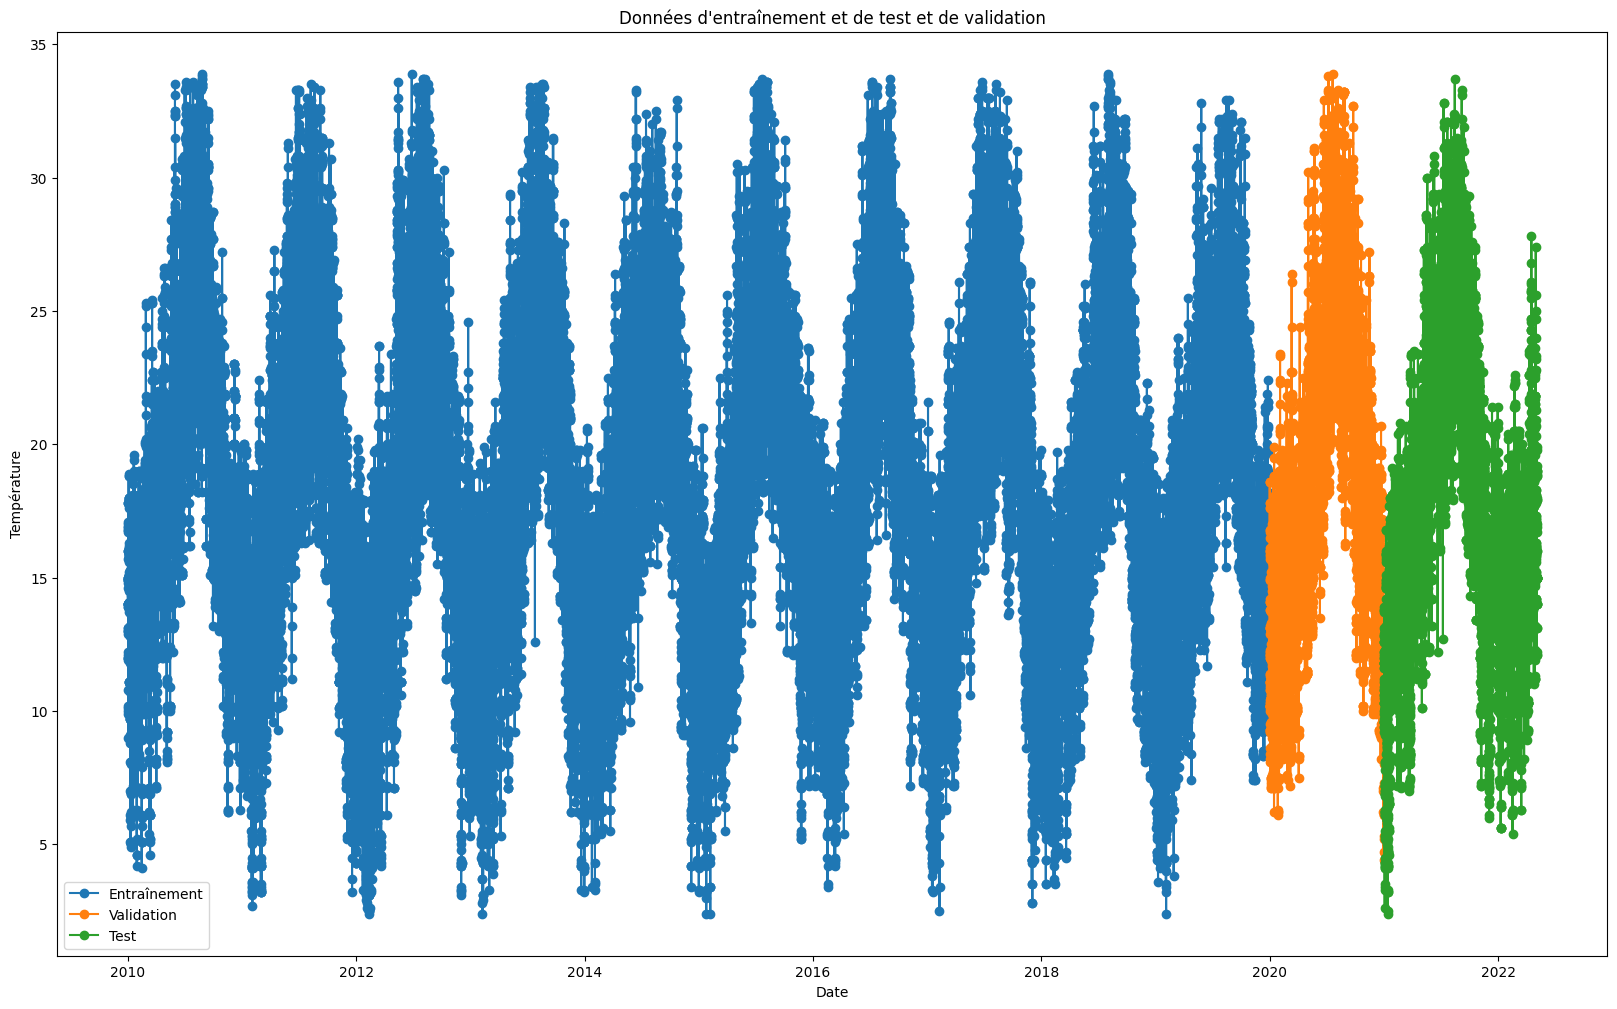

In [ ]:
# Créer un graphe
plt.figure(figsize=(20, 12))

# Tracer les données d'entraînement
plt.plot(train_data.index, y_train, label='Entraînement', marker='o')

# Tracer les données de test
plt.plot(val_data.index, y_val, label='Validation', marker='o')

# Tracer les données de test
plt.plot(test_data.index, y_test, label='Test', marker='o')

# Ajouter des étiquettes et un titre
plt.xlabel('Date')
plt.ylabel('Température')
plt.title('Données d\'entraînement et de test et de validation')

# Ajouter une légende
plt.legend()

<font size='4' face='MathJax_Math-italic'>

# **<font color="#FF1646" >1. Modèles Non Linéaires </font>**

## **<font color='blue' >ExtraTreesRegressor</font>**
L'ExtraTreesRegressor est un modèle d'ensemble basé sur des arbres de décision qui favorise la diversité en utilisant des stratégies d'échantillonnage aléatoire supplémentaires lors de la construction des arbres. Cela peut conduire à de bonnes performances, en particulier dans des situations où la variabilité est élevée.


### **Comment fonctionne ExtraTreesRegressor ?**

L'ExtraTreesRegressor fonctionne de manière similaire au RandomForestRegressor et à d'autres algorithmes basés sur des arbres de décision. Cependant, il existe quelques différences clés dans le processus de construction des arbres de décision et la manière dont les prédictions sont faites.

* #### **Ensemble d'arbres de décision :** Tout comme le RandomForestRegressor, l'ExtraTreesRegressor est un modèle basé sur un ensemble d'arbres de décision. Il crée plusieurs arbres de décision indépendants les uns des autres.

* #### **Échantillonnage aléatoire :** Lors de la construction de chaque arbre, l'algorithme utilise un échantillonnage aléatoire (bootstrap) pour sélectionner les observations d'entraînement. Cependant, contrairement au RandomForestRegressor, l'ExtraTreesRegressor utilise également une sélection aléatoire des seuils de division à chaque nœud.

* #### **Division des nœuds :** À chaque nœud de l'arbre, l'algorithme sélectionne non seulement une sous-section aléatoire des observations, mais il utilise également une sous-section aléatoire des caractéristiques pour choisir le meilleur seuil de division. Cela ajoute une autre couche de diversité aux arbres.

* #### **Moyenne des prédictions :** Lors de la prédiction, chaque arbre de l'ensemble donne sa propre prédiction, et la prédiction finale de l'ExtraTreesRegressor est obtenue en moyennant ces prédictions (pour la régression).

* #### **Robustesse au surajustement :** En raison de la diversité accrue introduite par l'échantillonnage aléatoire des observations et des caractéristiques, l'ExtraTreesRegressor est généralement robuste au surajustement. Cela signifie qu'il peut mieux généraliser à de nouvelles données.

* #### **Paramètres :** Les paramètres de l'ExtraTreesRegressor incluent le nombre d'arbres (n_estimators), la profondeur maximale des arbres (max_depth), le nombre minimum d'observations requises pour diviser un nœud (min_samples_split), et le nombre minimum d'observations requises dans une feuille (min_samples_leaf).




## **<font color='green' >Construction du model</font>**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Définir les valeurs à tester pour n_estimators
n_estimators_values = range(1, 50)

# Initialiser les listes pour stocker les résultats
test_scores_et = []
train_scores_et = []
errors_et = []

for n_estimators in n_estimators_values:
    # Créer un modèle ExtraTreesRegressor avec la valeur actuelle de n_estimators
    et_regressor = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1, verbose=3)

    # Entraîner le modèle sur l'ensemble d'entraînement
    et_regressor.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred_et = et_regressor.predict(X_test)

    # Stocker les scores pour l'analyse ultérieure
    train_scores_et.append(et_regressor.score(X_train, y_train))
    test_scores_et.append(et_regressor.score(X_test, y_test))

    # Stocker les erreurs pour l'analyse ultérieure
    errors_et.append(mean_squared_error(y_test, y_pred_et))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 2building tree 2 of 2



[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 5
building tree 2 of 5
building tree 3 of 5building tree 4 of 5

building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 6
building tree 2 of 6
building tree 3 of 6building tree 4 of 6
building tree 5 of 6
building tree 6 of 6



[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 7building tree 2 of 7

building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7


[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8building tree 7 of 8
building tree 8 of 8



[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remain

building tree 1 of 9
building tree 2 of 9
building tree 3 of 9building tree 4 of 9

building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    0.0s remain

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.0s remain

building tree 1 of 11building tree 2 of 11
building tree 3 of 11

building tree 4 of 11
building tree 5 of 11building tree 6 of 11
building tree 7 of 11
building tree 8 of 11

building tree 9 of 11
building tree 10 of 11
building tree 11 of 11


[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  11 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  11 | elapsed:    0.0s remain

building tree 1 of 12building tree 2 of 12

building tree 3 of 12
building tree 4 of 12
building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    0.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  12 | elapsed:    0.0s remain

building tree 1 of 13
building tree 2 of 13
building tree 3 of 13
building tree 4 of 13building tree 5 of 13

building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13


[Parallel(n_jobs=-1)]: Done   3 out of  13 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  13 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  13 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of  13 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  13 | elapsed:    0.0s remain

building tree 1 of 14
building tree 2 of 14
building tree 3 of 14
building tree 4 of 14
building tree 5 of 14
building tree 6 of 14
building tree 7 of 14
building tree 8 of 14
building tree 9 of 14
building tree 10 of 14building tree 11 of 14
building tree 12 of 14

building tree 13 of 14
building tree 14 of 14


[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  14 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   9 out of  14 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  14 | elapsed:    0.0s remain

building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15building tree 13 of 15

building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    0.0s remain

building tree 1 of 16
building tree 2 of 16
building tree 3 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    0.0s remain

building tree 1 of 17
building tree 2 of 17
building tree 3 of 17
building tree 4 of 17
building tree 5 of 17
building tree 6 of 17building tree 7 of 17
building tree 8 of 17

building tree 9 of 17
building tree 10 of 17
building tree 11 of 17
building tree 12 of 17
building tree 13 of 17
building tree 14 of 17
building tree 15 of 17
building tree 16 of 17


[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.5s remaining:    0.6s


building tree 17 of 17


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  17 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    0.0s remaini

building tree 1 of 18
building tree 2 of 18
building tree 3 of 18
building tree 4 of 18
building tree 5 of 18
building tree 6 of 18
building tree 7 of 18
building tree 8 of 18
building tree 9 of 18
building tree 10 of 18
building tree 11 of 18building tree 12 of 18

building tree 13 of 18
building tree 14 of 18
building tree 15 of 18
building tree 16 of 18
building tree 17 of 18
building tree 18 of 18


[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:    1.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 19
building tree 2 of 19building tree 3 of 19
building tree 4 of 19

building tree 5 of 19
building tree 6 of 19building tree 7 of 19
building tree 8 of 19

building tree 9 of 19
building tree 10 of 19
building tree 11 of 19
building tree 12 of 19
building tree 13 of 19building tree 14 of 19

building tree 15 of 19
building tree 16 of 19
building tree 17 of 19
building tree 18 of 19
building tree 19 of 19


[Parallel(n_jobs=-1)]: Done  11 out of  19 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of  19 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20building tree 10 of 20

building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 21
building tree 2 of 21building tree 3 of 21
building tree 4 of 21
building tree 5 of 21
building tree 6 of 21
building tree 7 of 21

building tree 8 of 21
building tree 9 of 21
building tree 10 of 21
building tree 11 of 21
building tree 12 of 21
building tree 13 of 21
building tree 14 of 21
building tree 15 of 21
building tree 16 of 21
building tree 17 of 21
building tree 18 of 21
building tree 19 of 21
building tree 20 of 21
building tree 21 of 21


[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  14 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  14 out of  21 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  14 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 22
building tree 2 of 22
building tree 3 of 22
building tree 4 of 22
building tree 5 of 22
building tree 6 of 22
building tree 7 of 22building tree 8 of 22

building tree 9 of 22
building tree 10 of 22
building tree 11 of 22
building tree 12 of 22
building tree 13 of 22
building tree 14 of 22
building tree 15 of 22
building tree 16 of 22
building tree 17 of 22
building tree 18 of 22
building tree 19 of 22
building tree 20 of 22
building tree 21 of 22
building tree 22 of 22


[Parallel(n_jobs=-1)]: Done  15 out of  22 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  22 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 23
building tree 2 of 23
building tree 3 of 23
building tree 4 of 23
building tree 5 of 23
building tree 6 of 23
building tree 7 of 23
building tree 8 of 23
building tree 9 of 23
building tree 10 of 23
building tree 11 of 23
building tree 12 of 23
building tree 13 of 23building tree 14 of 23

building tree 15 of 23
building tree 16 of 23
building tree 17 of 23
building tree 18 of 23
building tree 19 of 23
building tree 20 of 23
building tree 21 of 23
building tree 22 of 23
building tree 23 of 23


[Parallel(n_jobs=-1)]: Done  16 out of  23 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  23 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 24
building tree 2 of 24
building tree 3 of 24
building tree 4 of 24building tree 5 of 24
building tree 6 of 24

building tree 7 of 24
building tree 8 of 24
building tree 9 of 24
building tree 10 of 24building tree 11 of 24

building tree 12 of 24
building tree 13 of 24
building tree 14 of 24
building tree 15 of 24
building tree 16 of 24
building tree 17 of 24
building tree 18 of 24
building tree 19 of 24
building tree 20 of 24
building tree 21 of 24
building tree 22 of 24
building tree 23 of 24
building tree 24 of 24


[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  18 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  18 out of  24 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  18 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25building tree 7 of 25

building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25building tree 12 of 25

building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  19 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  19 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  19 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 26building tree 2 of 26building tree 3 of 26
building tree 4 of 26


building tree 5 of 26
building tree 6 of 26
building tree 7 of 26
building tree 8 of 26
building tree 9 of 26
building tree 10 of 26
building tree 11 of 26
building tree 12 of 26
building tree 13 of 26
building tree 14 of 26
building tree 15 of 26
building tree 16 of 26
building tree 17 of 26
building tree 18 of 26
building tree 19 of 26
building tree 20 of 26
building tree 21 of 26
building tree 22 of 26
building tree 23 of 26
building tree 24 of 26
building tree 25 of 26
building tree 26 of 26


[Parallel(n_jobs=-1)]: Done  20 out of  26 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  26 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  26 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 27
building tree 2 of 27
building tree 3 of 27
building tree 4 of 27
building tree 5 of 27
building tree 6 of 27
building tree 7 of 27
building tree 8 of 27
building tree 9 of 27
building tree 10 of 27
building tree 11 of 27building tree 12 of 27
building tree 13 of 27

building tree 14 of 27
building tree 15 of 27
building tree 16 of 27
building tree 17 of 27
building tree 18 of 27
building tree 19 of 27
building tree 20 of 27
building tree 21 of 27
building tree 22 of 27
building tree 23 of 27
building tree 24 of 27
building tree 25 of 27
building tree 26 of 27
building tree 27 of 27


[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  22 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  22 out of  27 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  22 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 28
building tree 2 of 28
building tree 3 of 28
building tree 4 of 28
building tree 5 of 28
building tree 6 of 28
building tree 7 of 28building tree 8 of 28

building tree 9 of 28
building tree 10 of 28
building tree 11 of 28building tree 12 of 28

building tree 13 of 28
building tree 14 of 28
building tree 15 of 28
building tree 16 of 28
building tree 17 of 28
building tree 18 of 28
building tree 19 of 28
building tree 20 of 28
building tree 21 of 28
building tree 22 of 28
building tree 23 of 28
building tree 24 of 28
building tree 25 of 28
building tree 26 of 28
building tree 27 of 28
building tree 28 of 28


[Parallel(n_jobs=-1)]: Done  23 out of  28 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  28 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  28 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 29building tree 2 of 29building tree 3 of 29

building tree 4 of 29
building tree 5 of 29
building tree 6 of 29
building tree 7 of 29

building tree 8 of 29
building tree 9 of 29
building tree 10 of 29
building tree 11 of 29
building tree 12 of 29
building tree 13 of 29
building tree 14 of 29building tree 15 of 29

building tree 16 of 29
building tree 17 of 29
building tree 18 of 29
building tree 19 of 29
building tree 20 of 29
building tree 21 of 29
building tree 22 of 29
building tree 23 of 29
building tree 24 of 29
building tree 25 of 29
building tree 26 of 29
building tree 27 of 29
building tree 28 of 29
building tree 29 of 29


[Parallel(n_jobs=-1)]: Done  24 out of  29 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  29 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  29 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 31
building tree 2 of 31
building tree 3 of 31
building tree 4 of 31
building tree 5 of 31
building tree 6 of 31
building tree 7 of 31
building tree 8 of 31
building tree 9 of 31
building tree 10 of 31
building tree 11 of 31
building tree 12 of 31
building tree 13 of 31
building tree 14 of 31
building tree 15 of 31
building tree 16 of 31
building tree 17 of 31
building tree 18 of 31
building tree 19 of 31
building tree 20 of 31
building tree 21 of 31
building tree 22 of 31
building tree 23 of 31
building tree 24 of 31


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 31
building tree 26 of 31
building tree 27 of 31
building tree 28 of 31
building tree 29 of 31
building tree 30 of 31
building tree 31 of 31


[Parallel(n_jobs=-1)]: Done  27 out of  31 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  31 out of  31 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  27 out of  31 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  31 out of  31 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  27 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  31 out of  31 | e

building tree 1 of 32building tree 2 of 32

building tree 3 of 32
building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s


building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=-1)]: Done  28 out of  32 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  28 out of  32 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  28 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  32 out of  32 | e

building tree 1 of 33
building tree 2 of 33
building tree 3 of 33
building tree 4 of 33
building tree 5 of 33
building tree 6 of 33building tree 7 of 33

building tree 8 of 33
building tree 9 of 33
building tree 10 of 33
building tree 11 of 33
building tree 12 of 33
building tree 13 of 33
building tree 14 of 33
building tree 15 of 33
building tree 16 of 33
building tree 17 of 33
building tree 18 of 33
building tree 19 of 33
building tree 20 of 33
building tree 21 of 33
building tree 22 of 33
building tree 23 of 33
building tree 24 of 33


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 33
building tree 26 of 33
building tree 27 of 33
building tree 28 of 33
building tree 29 of 33
building tree 30 of 33
building tree 31 of 33
building tree 32 of 33
building tree 33 of 33


[Parallel(n_jobs=-1)]: Done  30 out of  33 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  30 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  33 out of  33 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  30 out of  33 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  33 out of  33 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  30 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  33 out of  33 | e

building tree 1 of 34building tree 2 of 34
building tree 3 of 34
building tree 4 of 34
building tree 5 of 34
building tree 6 of 34

building tree 7 of 34
building tree 8 of 34
building tree 9 of 34building tree 10 of 34

building tree 11 of 34
building tree 12 of 34
building tree 13 of 34
building tree 14 of 34
building tree 15 of 34
building tree 16 of 34
building tree 17 of 34
building tree 18 of 34
building tree 19 of 34
building tree 20 of 34
building tree 21 of 34
building tree 22 of 34
building tree 23 of 34
building tree 24 of 34


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 34
building tree 26 of 34
building tree 27 of 34
building tree 28 of 34building tree 29 of 34

building tree 30 of 34building tree 31 of 34

building tree 32 of 34
building tree 33 of 34
building tree 34 of 34


[Parallel(n_jobs=-1)]: Done  31 out of  34 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  31 out of  34 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  34 out of  34 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  31 out of  34 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  34 out of  34 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  31 out of  34 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  34 out of  34 | e

building tree 1 of 35building tree 2 of 35building tree 3 of 35
building tree 4 of 35
building tree 5 of 35
building tree 6 of 35


building tree 7 of 35building tree 8 of 35

building tree 9 of 35
building tree 10 of 35
building tree 11 of 35
building tree 12 of 35
building tree 13 of 35
building tree 14 of 35
building tree 15 of 35
building tree 16 of 35
building tree 17 of 35
building tree 18 of 35building tree 19 of 35

building tree 20 of 35
building tree 21 of 35
building tree 22 of 35
building tree 23 of 35
building tree 24 of 35


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 35
building tree 26 of 35
building tree 27 of 35
building tree 28 of 35
building tree 29 of 35
building tree 30 of 35
building tree 31 of 35
building tree 32 of 35
building tree 33 of 35
building tree 34 of 35
building tree 35 of 35


[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  32 out of  35 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  32 out of  35 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  32 out of  35 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  35 out of  35 | e

building tree 1 of 36
building tree 2 of 36
building tree 3 of 36
building tree 4 of 36
building tree 5 of 36
building tree 6 of 36
building tree 7 of 36
building tree 8 of 36
building tree 9 of 36
building tree 10 of 36
building tree 11 of 36
building tree 12 of 36
building tree 13 of 36
building tree 14 of 36
building tree 15 of 36
building tree 16 of 36
building tree 17 of 36
building tree 18 of 36
building tree 19 of 36
building tree 20 of 36
building tree 21 of 36
building tree 22 of 36
building tree 23 of 36
building tree 24 of 36


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 36
building tree 26 of 36
building tree 27 of 36building tree 28 of 36
building tree 29 of 36

building tree 30 of 36building tree 31 of 36

building tree 32 of 36
building tree 33 of 36
building tree 34 of 36
building tree 35 of 36
building tree 36 of 36


[Parallel(n_jobs=-1)]: Done  34 out of  36 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 out of  36 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 out of  36 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 out of  36 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  36 | e

building tree 1 of 37building tree 2 of 37
building tree 3 of 37
building tree 4 of 37
building tree 5 of 37
building tree 6 of 37

building tree 7 of 37
building tree 8 of 37
building tree 9 of 37
building tree 10 of 37
building tree 11 of 37
building tree 12 of 37
building tree 13 of 37
building tree 14 of 37
building tree 15 of 37
building tree 16 of 37
building tree 17 of 37
building tree 18 of 37building tree 19 of 37

building tree 20 of 37
building tree 21 of 37
building tree 22 of 37
building tree 23 of 37
building tree 24 of 37


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s


building tree 25 of 37building tree 26 of 37

building tree 27 of 37
building tree 28 of 37
building tree 29 of 37building tree 30 of 37

building tree 31 of 37
building tree 32 of 37
building tree 33 of 37
building tree 34 of 37
building tree 35 of 37
building tree 36 of 37
building tree 37 of 37


[Parallel(n_jobs=-1)]: Done  35 out of  37 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  35 out of  37 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  37 out of  37 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  35 out of  37 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  37 out of  37 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  35 out of  37 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  37 out of  37 | e

building tree 1 of 38building tree 2 of 38

building tree 3 of 38
building tree 4 of 38
building tree 5 of 38
building tree 6 of 38
building tree 7 of 38
building tree 8 of 38
building tree 9 of 38
building tree 10 of 38
building tree 11 of 38
building tree 12 of 38
building tree 13 of 38
building tree 14 of 38
building tree 15 of 38
building tree 16 of 38
building tree 17 of 38
building tree 18 of 38
building tree 19 of 38
building tree 20 of 38building tree 21 of 38

building tree 22 of 38
building tree 23 of 38
building tree 24 of 38


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 38
building tree 26 of 38
building tree 27 of 38
building tree 28 of 38
building tree 29 of 38
building tree 30 of 38
building tree 31 of 38
building tree 32 of 38
building tree 33 of 38
building tree 34 of 38
building tree 35 of 38
building tree 36 of 38
building tree 37 of 38
building tree 38 of 38


[Parallel(n_jobs=-1)]: Done  36 out of  38 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | e

building tree 1 of 39
building tree 2 of 39building tree 3 of 39
building tree 4 of 39
building tree 5 of 39

building tree 6 of 39
building tree 7 of 39building tree 8 of 39

building tree 9 of 39
building tree 10 of 39
building tree 11 of 39
building tree 12 of 39
building tree 13 of 39
building tree 14 of 39building tree 15 of 39

building tree 16 of 39
building tree 17 of 39
building tree 18 of 39
building tree 19 of 39
building tree 20 of 39
building tree 21 of 39
building tree 22 of 39
building tree 23 of 39
building tree 24 of 39


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 39
building tree 26 of 39
building tree 27 of 39
building tree 28 of 39building tree 29 of 39

building tree 30 of 39
building tree 31 of 39
building tree 32 of 39
building tree 33 of 39
building tree 34 of 39
building tree 35 of 39
building tree 36 of 39
building tree 37 of 39
building tree 38 of 39
building tree 39 of 39


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  39 out of  39 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  39 out of  39 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  39 out of  39 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40building tree 8 of 40

building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40building tree 24 of 40



[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 40
building tree 26 of 40
building tree 27 of 40building tree 28 of 40

building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40building tree 39 of 40

building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 41
building tree 2 of 41
building tree 3 of 41building tree 4 of 41
building tree 5 of 41
building tree 6 of 41
building tree 7 of 41
building tree 8 of 41

building tree 9 of 41building tree 10 of 41

building tree 11 of 41building tree 12 of 41

building tree 13 of 41
building tree 14 of 41
building tree 15 of 41
building tree 16 of 41
building tree 17 of 41
building tree 18 of 41
building tree 19 of 41
building tree 20 of 41
building tree 21 of 41building tree 22 of 41

building tree 23 of 41
building tree 24 of 41


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s


building tree 25 of 41
building tree 26 of 41
building tree 27 of 41
building tree 28 of 41
building tree 29 of 41
building tree 30 of 41
building tree 31 of 41
building tree 32 of 41
building tree 33 of 41building tree 34 of 41

building tree 35 of 41
building tree 36 of 41
building tree 37 of 41
building tree 38 of 41building tree 39 of 41

building tree 40 of 41
building tree 41 of 41


[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  41 out of  41 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  41 out of  41 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  41 out of  41 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 42
building tree 2 of 42
building tree 3 of 42
building tree 4 of 42
building tree 5 of 42
building tree 6 of 42
building tree 7 of 42
building tree 8 of 42
building tree 9 of 42
building tree 10 of 42
building tree 11 of 42
building tree 12 of 42
building tree 13 of 42
building tree 14 of 42
building tree 15 of 42
building tree 16 of 42
building tree 17 of 42
building tree 18 of 42
building tree 19 of 42
building tree 20 of 42
building tree 21 of 42
building tree 22 of 42
building tree 23 of 42
building tree 24 of 42


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s


building tree 25 of 42
building tree 26 of 42
building tree 27 of 42
building tree 28 of 42
building tree 29 of 42
building tree 30 of 42
building tree 31 of 42
building tree 32 of 42
building tree 33 of 42
building tree 34 of 42
building tree 35 of 42
building tree 36 of 42
building tree 37 of 42
building tree 38 of 42
building tree 39 of 42
building tree 40 of 42
building tree 41 of 42
building tree 42 of 42


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 43
building tree 2 of 43
building tree 3 of 43
building tree 4 of 43
building tree 5 of 43
building tree 6 of 43
building tree 7 of 43
building tree 8 of 43
building tree 9 of 43
building tree 10 of 43
building tree 11 of 43
building tree 12 of 43
building tree 13 of 43
building tree 14 of 43
building tree 15 of 43
building tree 16 of 43
building tree 17 of 43
building tree 18 of 43
building tree 19 of 43
building tree 20 of 43
building tree 21 of 43
building tree 22 of 43
building tree 23 of 43
building tree 24 of 43


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 43
building tree 26 of 43
building tree 27 of 43
building tree 28 of 43
building tree 29 of 43
building tree 30 of 43
building tree 31 of 43
building tree 32 of 43
building tree 33 of 43
building tree 34 of 43
building tree 35 of 43
building tree 36 of 43
building tree 37 of 43
building tree 38 of 43
building tree 39 of 43
building tree 40 of 43
building tree 41 of 43
building tree 42 of 43
building tree 43 of 43


[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 44
building tree 2 of 44
building tree 3 of 44building tree 4 of 44
building tree 5 of 44
building tree 6 of 44
building tree 7 of 44
building tree 8 of 44

building tree 9 of 44
building tree 10 of 44
building tree 11 of 44
building tree 12 of 44
building tree 13 of 44
building tree 14 of 44building tree 15 of 44

building tree 16 of 44
building tree 17 of 44
building tree 18 of 44
building tree 19 of 44
building tree 20 of 44
building tree 21 of 44
building tree 22 of 44
building tree 23 of 44
building tree 24 of 44


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 44
building tree 26 of 44
building tree 27 of 44
building tree 28 of 44
building tree 29 of 44
building tree 30 of 44
building tree 31 of 44
building tree 32 of 44
building tree 33 of 44
building tree 34 of 44
building tree 35 of 44
building tree 36 of 44
building tree 37 of 44
building tree 38 of 44
building tree 39 of 44
building tree 40 of 44
building tree 41 of 44
building tree 42 of 44
building tree 43 of 44
building tree 44 of 44


[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  44 out of  44 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  44 out of  44 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  44 out of  44 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 45
building tree 2 of 45building tree 3 of 45
building tree 4 of 45

building tree 5 of 45
building tree 6 of 45
building tree 7 of 45
building tree 8 of 45
building tree 9 of 45building tree 10 of 45

building tree 11 of 45building tree 12 of 45
building tree 13 of 45

building tree 14 of 45
building tree 15 of 45
building tree 16 of 45
building tree 17 of 45
building tree 18 of 45
building tree 19 of 45
building tree 20 of 45building tree 21 of 45

building tree 22 of 45
building tree 23 of 45
building tree 24 of 45


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 45
building tree 26 of 45
building tree 27 of 45
building tree 28 of 45
building tree 29 of 45
building tree 30 of 45
building tree 31 of 45
building tree 32 of 45
building tree 33 of 45
building tree 34 of 45
building tree 35 of 45
building tree 36 of 45
building tree 37 of 45
building tree 38 of 45
building tree 39 of 45
building tree 40 of 45
building tree 41 of 45
building tree 42 of 45
building tree 43 of 45
building tree 44 of 45
building tree 45 of 45


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 46
building tree 2 of 46
building tree 3 of 46building tree 4 of 46

building tree 5 of 46
building tree 6 of 46
building tree 7 of 46building tree 8 of 46

building tree 9 of 46
building tree 10 of 46
building tree 11 of 46
building tree 12 of 46
building tree 13 of 46building tree 14 of 46

building tree 15 of 46
building tree 16 of 46
building tree 17 of 46
building tree 18 of 46
building tree 19 of 46
building tree 20 of 46
building tree 21 of 46
building tree 22 of 46
building tree 23 of 46
building tree 24 of 46


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s


building tree 25 of 46
building tree 26 of 46
building tree 27 of 46
building tree 28 of 46
building tree 29 of 46
building tree 30 of 46
building tree 31 of 46
building tree 32 of 46
building tree 33 of 46
building tree 34 of 46
building tree 35 of 46
building tree 36 of 46
building tree 37 of 46
building tree 38 of 46
building tree 39 of 46
building tree 40 of 46
building tree 41 of 46
building tree 42 of 46
building tree 43 of 46
building tree 44 of 46
building tree 45 of 46
building tree 46 of 46


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  46 out of  46 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  46 out of  46 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  46 out of  46 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 47
building tree 2 of 47
building tree 3 of 47
building tree 4 of 47
building tree 5 of 47
building tree 6 of 47
building tree 7 of 47
building tree 8 of 47
building tree 9 of 47
building tree 10 of 47
building tree 11 of 47
building tree 12 of 47
building tree 13 of 47
building tree 14 of 47
building tree 15 of 47
building tree 16 of 47
building tree 17 of 47
building tree 18 of 47
building tree 19 of 47
building tree 20 of 47
building tree 21 of 47
building tree 22 of 47
building tree 23 of 47
building tree 24 of 47


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 47
building tree 26 of 47
building tree 27 of 47
building tree 28 of 47
building tree 29 of 47
building tree 30 of 47
building tree 31 of 47
building tree 32 of 47
building tree 33 of 47
building tree 34 of 47
building tree 35 of 47
building tree 36 of 47
building tree 37 of 47
building tree 38 of 47
building tree 39 of 47
building tree 40 of 47
building tree 41 of 47
building tree 42 of 47
building tree 43 of 47
building tree 44 of 47
building tree 45 of 47
building tree 46 of 47
building tree 47 of 47


[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 48
building tree 2 of 48
building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48building tree 10 of 48

building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48building tree 31 of 48

building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48
building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 49building tree 2 of 49
building tree 3 of 49building tree 4 of 49

building tree 5 of 49
building tree 6 of 49
building tree 7 of 49

building tree 8 of 49
building tree 9 of 49
building tree 10 of 49
building tree 11 of 49
building tree 12 of 49
building tree 13 of 49
building tree 14 of 49
building tree 15 of 49
building tree 16 of 49
building tree 17 of 49
building tree 18 of 49
building tree 19 of 49
building tree 20 of 49
building tree 21 of 49
building tree 22 of 49
building tree 23 of 49
building tree 24 of 49


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s


building tree 25 of 49
building tree 26 of 49
building tree 27 of 49
building tree 28 of 49
building tree 29 of 49
building tree 30 of 49
building tree 31 of 49
building tree 32 of 49
building tree 33 of 49
building tree 34 of 49
building tree 35 of 49
building tree 36 of 49
building tree 37 of 49
building tree 38 of 49
building tree 39 of 49
building tree 40 of 49
building tree 41 of 49
building tree 42 of 49
building tree 43 of 49
building tree 44 of 49
building tree 45 of 49
building tree 46 of 49
building tree 47 of 49
building tree 48 of 49
building tree 49 of 49


[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  49 out of  49 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  49 out of  49 | elapsed:    0.1s finished


In [ ]:
test_scores_et

[0.9496258632849782,
 0.9738865519636368,
 0.9763751157076938,
 0.9815305480294477,
 0.9808309681318141,
 0.9799024172479286,
 0.9806451870845524,
 0.9814155907759888,
 0.9814054760951666,
 0.9826460563087915,
 0.9822165327872574,
 0.9816402776450541,
 0.981662729298987,
 0.9822889017012839,
 0.98322857957528,
 0.983339785850969,
 0.983548328424774,
 0.98441397186643,
 0.9842798666548714,
 0.9843089974092656,
 0.9842849090588487,
 0.9846458935805384,
 0.9843147717901384,
 0.9841739489956651,
 0.9844404171820279,
 0.9843944360386947,
 0.9842997724575147,
 0.9839684640662786,
 0.9837360376424289,
 0.9836107868370537,
 0.9837133628409176,
 0.9839964979124382,
 0.9846249332925218,
 0.9851972302832477,
 0.9851152672895974,
 0.9852763153661075,
 0.9853454924233237,
 0.9854637462741282,
 0.9854130515175779,
 0.985350076182385,
 0.985539692709947,
 0.9855204966319755,
 0.9856130976223342,
 0.985431276183543,
 0.9855307042319701,
 0.9856054704358395,
 0.9855703911561379,
 0.9854526362051612,
 0

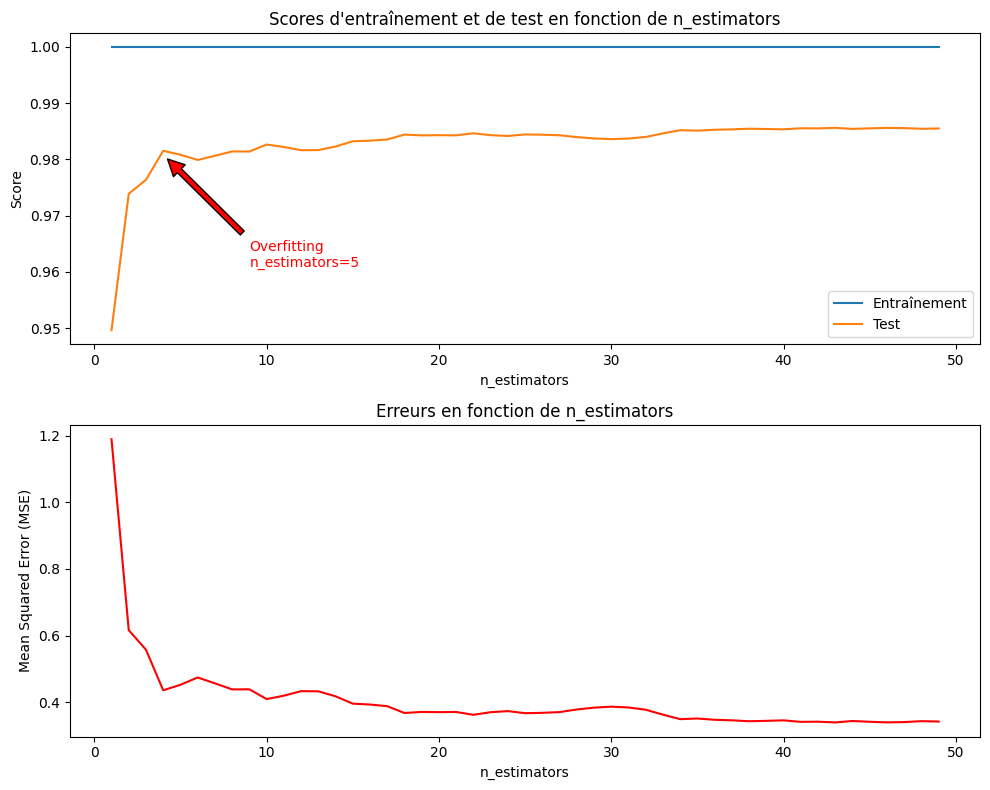

In [ ]:
# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Graphique des scores
ax1.plot(n_estimators_values, train_scores_et, label='Entraînement')
ax1.plot(n_estimators_values, test_scores_et, label='Test')
ax1.set_title('Scores d\'entraînement et de test en fonction de n_estimators')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Score')
ax1.legend()

# Graphique des erreurs
ax2.plot(n_estimators_values, errors_et, color='red')
ax2.set_title('Erreurs en fonction de n_estimators')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('Mean Squared Error (MSE)')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()


# Trouver l'indice du point où l'overfitting commence
overfitting_point = None
for i in range(1, len(test_scores_et)):
    if test_scores_et[i] <= test_scores_et[i - 1]:
        overfitting_point = i
        break

# Ajouter une annotation si l'overfitting est détecté
if overfitting_point is not None:
    n_estimators_at_overfitting = range(1, 50)[overfitting_point]
    ax1.annotate(f'Overfitting\nn_estimators={n_estimators_at_overfitting}',
                 xy=(overfitting_point, test_scores_et[overfitting_point]),
                 xytext=(overfitting_point + 5, test_scores_et[overfitting_point] - 0.02),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 fontsize=10, color='red')


# Afficher les graphiques
plt.show()

<font size='4' face='MathJax_Math-italic'>

## **<font color='blue' >Optimisation des hyper paramètres</font>**


In [ ]:
# Initialiser le modèle ExtraTreeRegressor
et_regressor = ExtraTreesRegressor(random_state=42)

# Définir les hyperparamètres à ajuster
param_grid_et = {
    'n_estimators': range(1,30),
    'max_depth': [ 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Mesurer le temps de début de la recherche par grille
et_grid_search_start_time = time.time()

# Utiliser la recherche sur grille pour trouver les meilleurs hyperparamètres
grid_search_et = GridSearchCV(et_regressor, param_grid_et, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Faire la recherche sur grille pour trouver les meilleurs hyperparamètres sur l'ensemble d'entraînement
grid_search_et.fit(X_train, y_train)

# Mesurer le temps de fin de la recherche par grille
et_grid_search_end_time = time.time()
et_grid_search_elapsed_time = et_grid_search_end_time - et_grid_search_start_time

# Afficher les meilleurs hyperparamètres
best_params_et = grid_search_et.best_params_
print("Meilleurs hyperparamètres:", best_params_et)


# Mesurer le temps de début de l'entraînement avec les meilleurs hyperparamètres
et_best_fit_start_time = time.time()

# Entraîner le modèle avec les meilleurs hyperparamètres sur l'ensemble d'entraînement complet
best_et_regressor = grid_search_et.best_estimator_
best_et_regressor.fit(X_train, y_train)

# Mesurer le temps de fin de l'entraînement
et_best_fit_end_time = time.time()
et_best_fit_elapsed_time = et_best_fit_end_time - et_best_fit_start_time

# Faire des prédictions sur l'ensemble de test
y_pred_et = best_et_regressor.predict(X_test)

# Afficher le temps écoulé pour la recherche par grille, l'entraînement et la prédiction
print(f"Temps écoulé pour la recherche par grille: {et_grid_search_elapsed_time} secondes")
print(f"Temps écoulé pour l'entraînement avec les meilleurs hyperparamètres: {et_best_fit_elapsed_time} secondes")

Fitting 3 folds for each of 783 candidates, totalling 2349 fits
Meilleurs hyperparamètres: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 27}
Temps écoulé pour la recherche par grille: 1204.2140367031097 secondes
Temps écoulé pour l'entraînement avec les meilleurs hyperparamètres: 7.634889364242554 secondes


Mean Squared Error: 0.37080190644815586


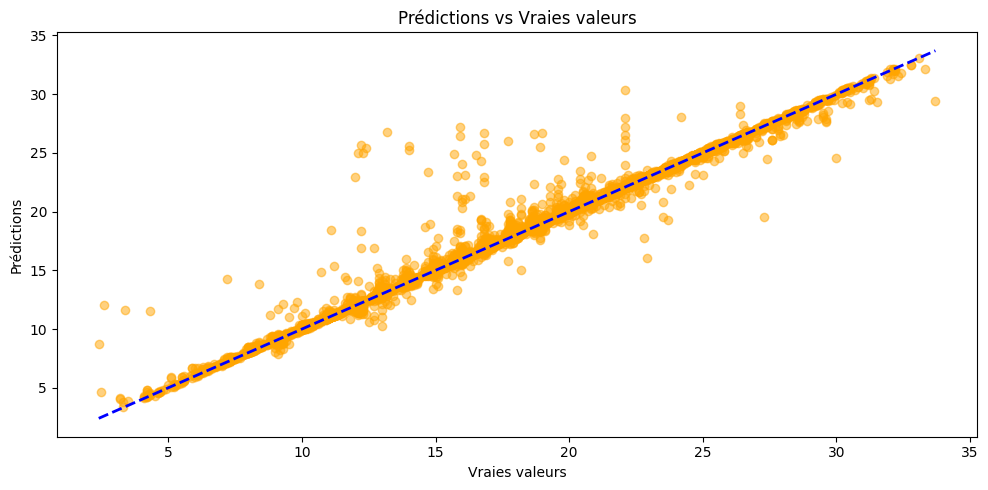

In [ ]:
# Afficher les prédictions par rapport aux vraies valeurs
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_et, color='orange', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='blue', linewidth=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Vraies valeurs')

# Calculer l'erreur quadratique moyenne (Mean Squared Error)
mse_et = mean_squared_error(y_test, y_pred_et)

print(f"Mean Squared Error: {mse_et}")

plt.tight_layout()
plt.show()

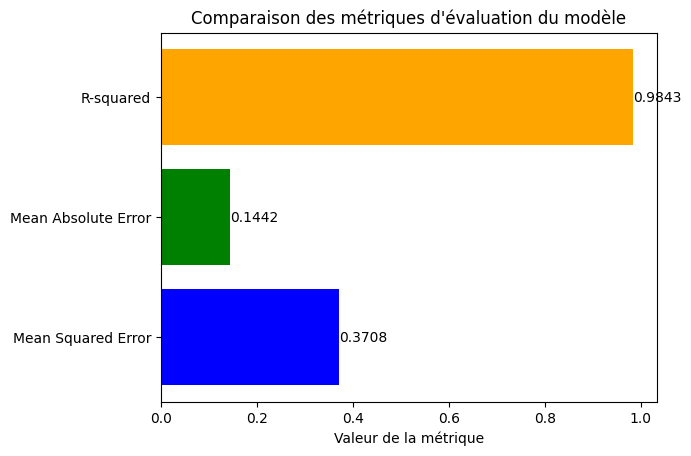

In [ ]:
# Calculer différentes métriques
mse_et = mean_squared_error(y_test, y_pred_et)
mae_et = mean_absolute_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)

# Mettre les métriques dans une liste pour faciliter la création du graphique
metrics_names = ['Mean Squared Error', 'Mean Absolute Error', 'R-squared']
metrics_values = [mse_et, mae_et, r2_et]

# Créer un graphique à barres horizontal
fig, ax = plt.subplots()
bars = ax.barh(metrics_names, metrics_values, color=['blue', 'green', 'orange'])

# Ajouter les valeurs à côté des barres
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}',
             va='center', ha='left', color='black')

plt.xlabel('Valeur de la métrique')
plt.title('Comparaison des métriques d\'évaluation du modèle')
plt.show()


In [ ]:
import joblib

# Enregistrer le modèle entraîné
model_filename = 'best_et_regressor_model.joblib'
joblib.dump(best_et_regressor, model_filename)

print(f"Modèle enregistré sous le nom '{model_filename}'")

Modèle enregistré sous le nom 'best_et_regressor_model.joblib'


<font size='4' face='MathJax_Math-italic'>

## **<font color='green' >Interprétabilité du model</font>**


Dans le domaine complexe et puissant de l'apprentissage automatique (machine learning), où des modèles sophistiqués sont capables d'effectuer des tâches complexes, l'interprétation des résultats devient essentielle. L'interprétabilité se réfère à la capacité de comprendre et d'expliquer le fonctionnement d'un modèle, en répondant aux questions cruciales telles que "Comment prend-il des décisions ?" ou "Pourquoi a-t-il prédit cela ?". Cette capacité à rendre les modèles compréhensibles est devenue une exigence fondamentale, en particulier dans des domaines sensibles tels que la santé, la finance et la justice, où des explications claires sont nécessaires.

L'interprétabilité peut être analysée à deux niveaux complémentaires : local et global :

## **<font color='orange' > Interprétabilité Locale :</font>**


L'interprétabilité locale se concentre sur la compréhension d'une prédiction spécifique générée par le modèle pour une observation particulière dans l'ensemble de données.

Elle répond à la question :

**"Pourquoi le modèle a-t-il pris cette décision pour cette observation spécifique ?"**



<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >SHAP (SHapley Additive exPlanations) </font>**
SHAP (SHapley Additive exPlanations) est basé sur la théorie des jeux et les valeurs de Shapley, qui proviennent du domaine de la théorie des coalitions. Cette méthode offre des explications individualisées et cohérentes pour les prédictions de modèles, que ce soit à l'échelle globale ou locale.

### **Interprétation Locale avec SHAP :**

* **Objectif :** Comprendre comment les caractéristiques influencent une prédiction spécifique du modèle pour une observation particulière.

* **Valeurs de Shapley Individuelles :**

  Pour une prédiction spécifique, SHAP attribue des valeurs de Shapley individuelles à chaque caractéristique. Ces valeurs représentent la contribution marginale de chaque caractéristique à la prédiction particulière.

* **Force de la Prédiction (Force Plot) :**

  Les "Force Plots" de SHAP illustrent graphiquement la contribution de chaque caractéristique à la différence entre la prédiction du modèle pour une instance spécifique et la valeur attendue (la valeur moyenne du modèle).

* **Graphiques d'Importance Locale :**

  Ces graphiques montrent visuellement comment chaque caractéristique contribue à la prédiction pour une observation donnée.




In [ ]:
!pip install shap

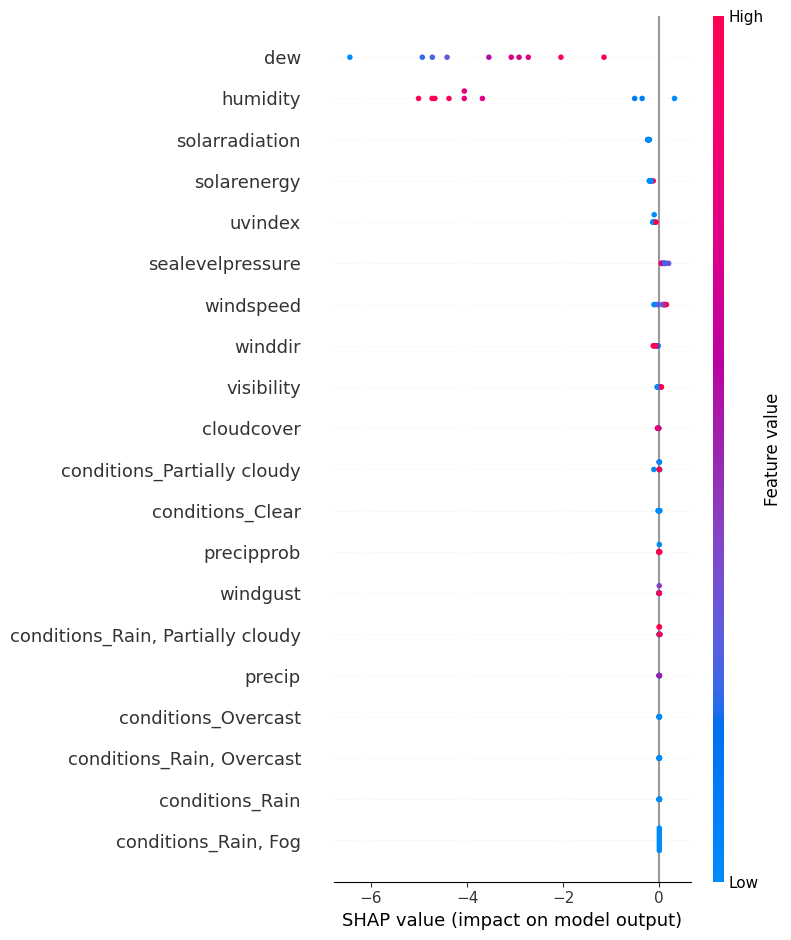

In [ ]:
import shap

# Initialiser un explorateur SHAP avec le modèle entraîné
explainer = shap.Explainer(best_et_regressor)

# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_test.iloc[:10, :])

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_test.iloc[:10, :])

<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >Profil Ceteris Paribus (CP)</font>**


Le Profil Ceteris Paribus (CP) est une méthode puissante que nous utilisons en statistiques et en apprentissage automatique pour plonger dans les rouages de nos modèles prédictifs. L'idée est de comprendre comment une variable spécifique influe sur les prédictions du modèle tout en maintenant les autres variables constantes, et cela se déroule en plusieurs étapes.

D'abord, on choisit un point de départ, une instance dans notre jeu de données. C'est comme notre point de référence pour l'analyse. Ensuite, on sélectionne la variable que l'on souhaite examiner, celle qui nous intrigue. On fixe alors les autres variables à un niveau spécifique, souvent à la moyenne, afin de les maintenir constantes.

La partie intéressante arrive quand on fait varier la valeur de la variable choisie. On crée une série de points le long d'une plage de valeurs, représentant différentes situations possibles. À chaque point, on demande à notre modèle de faire une prédiction en fonction de la variation de cette variable.

Enfin, on visualise ces prédictions. Un graphique est souvent la meilleure façon de voir comment la variable choisie impacte les prédictions du modèle. C'est là que l'expression "Ceteris Paribus" prend tout son sens, car on isole l'effet d'une seule variable, tout en gardant le reste constant.

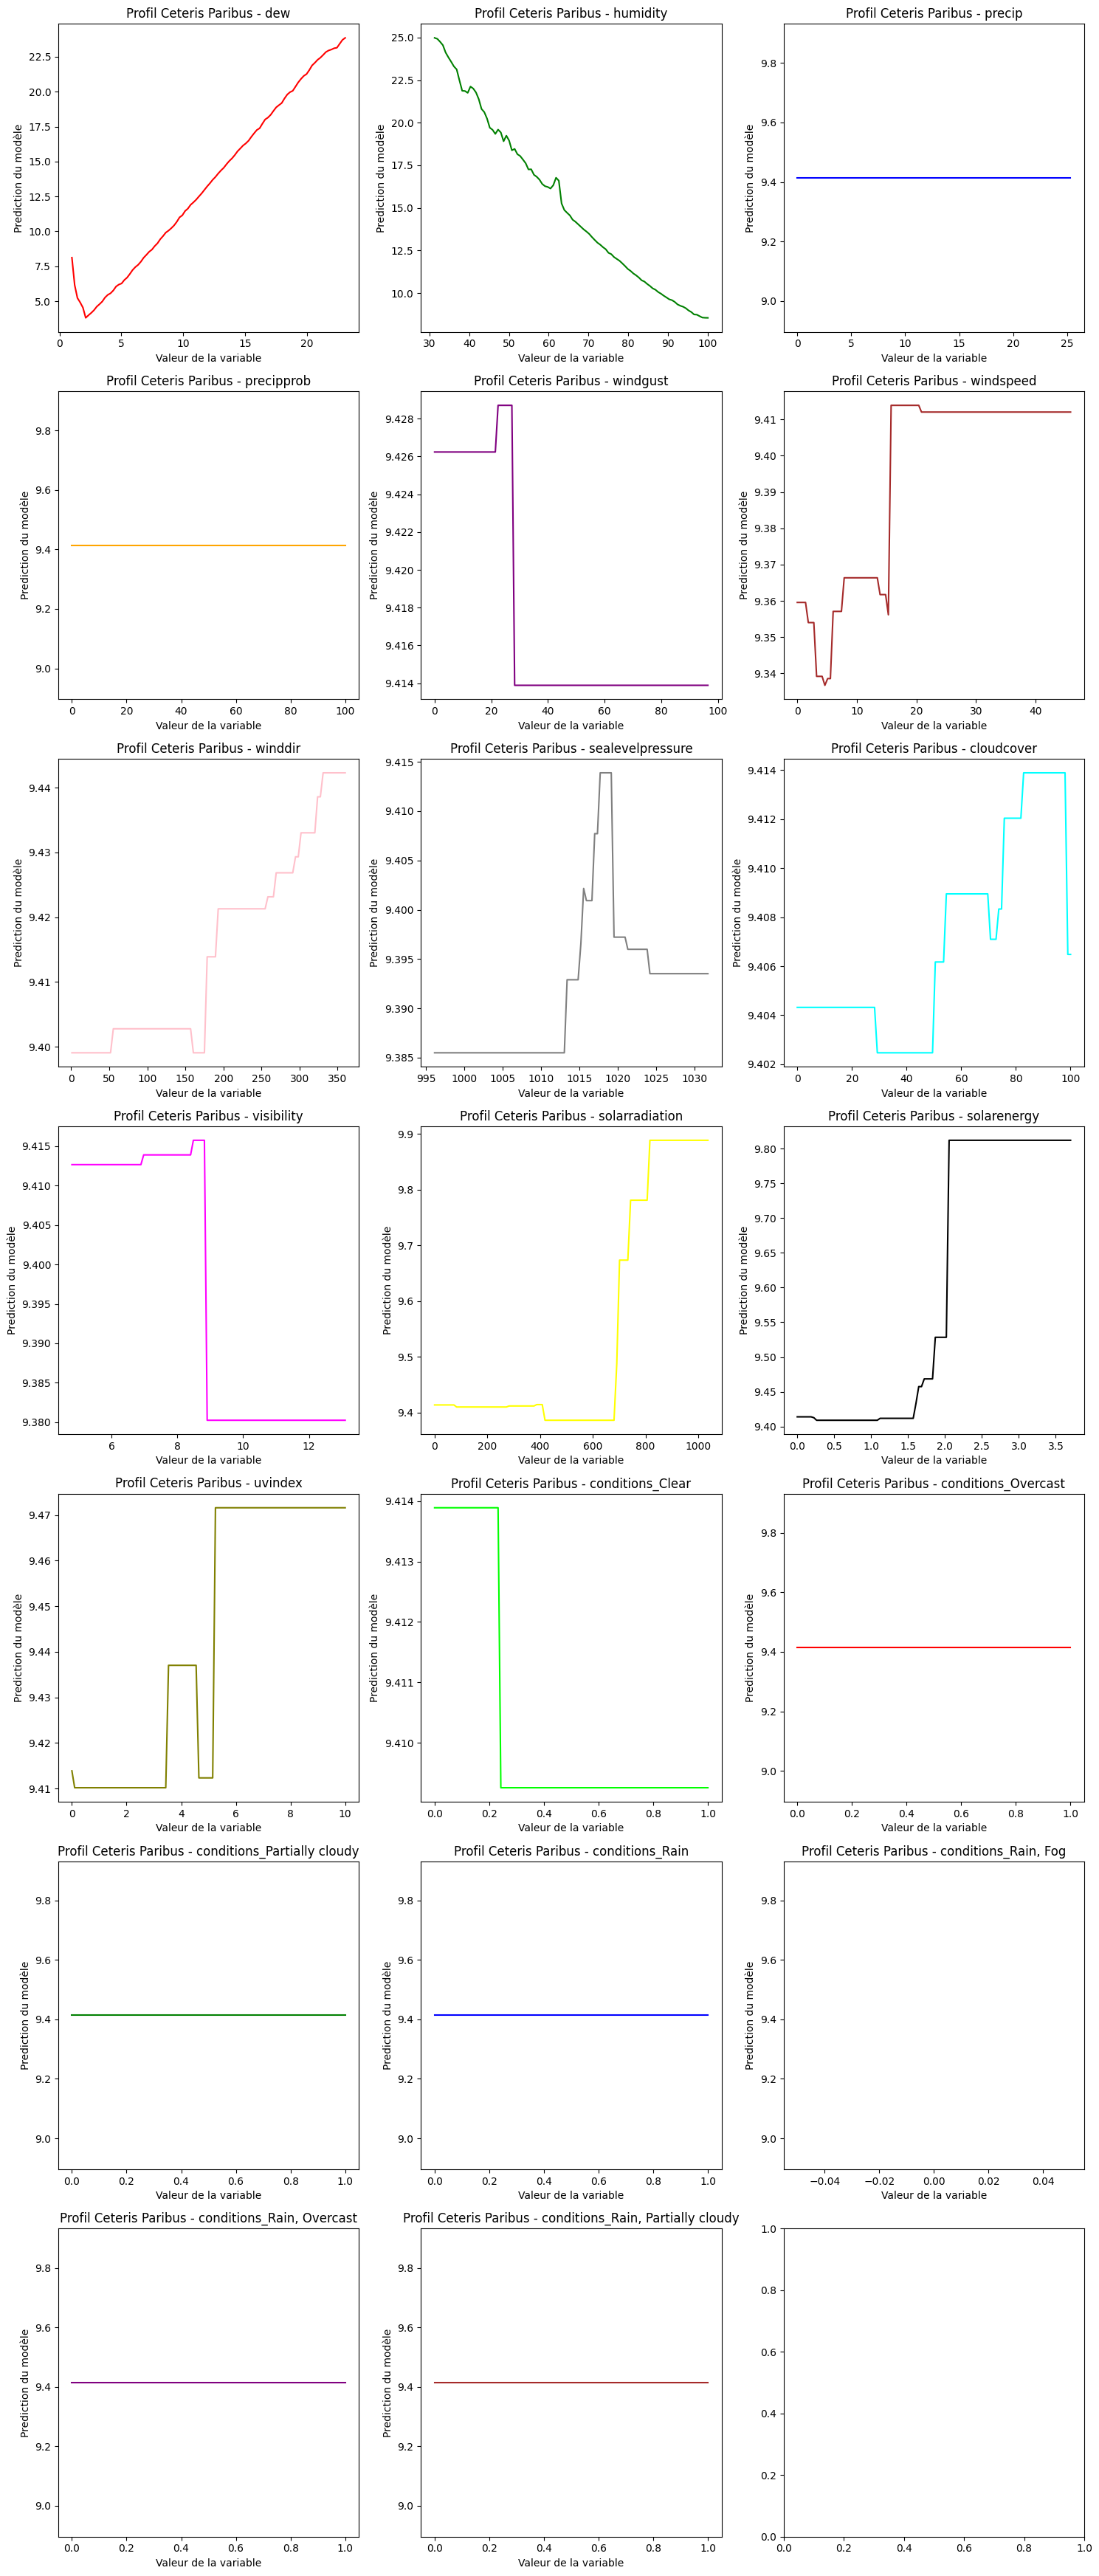

In [ ]:
import warnings
from pandas.errors import SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# Choisissez une instance spécifique
instance_to_profile = X_test.iloc[0, :]

# Fixez les autres variables (par exemple, à la moyenne)
fixed_values = X_test.mean()

# Définissez une liste de couleurs
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow', 'black', 'olive', 'lime']

# Faites varier chaque variable sur une plage donnée et stockez les graphiques
num_variables = len(X_test.columns)
num_plots_per_row = 3
num_rows = int(np.ceil(num_variables / num_plots_per_row))

# Définissez une grille de sous-graphiques (nombre de lignes, 3 colonnes)
fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))

# Aplatir les tableaux pour simplifier l'indexation
axs = axs.flatten()

for i, variable_to_vary in enumerate(X_test.columns):
    # Vérifiez si la variable est de type numérique
    if np.issubdtype(X_test[variable_to_vary].dtype, np.number):
        # Faites varier la variable choisie sur une plage donnée
        vary_range = np.linspace(X_test[variable_to_vary].min(), X_test[variable_to_vary].max(), 100)

        # Stockez les prédictions du modèle pour chaque valeur de la variable choisie
        predictions = []

        for value in vary_range:
            instance_copy = instance_to_profile.copy()
            instance_copy[variable_to_vary] = value
            instance_df = pd.DataFrame(instance_copy.values.reshape(1, -1), columns=X_test.columns)
            prediction = best_et_regressor.predict(instance_df)[0]

            predictions.append(prediction)

        # Créez un graphique pour chaque variable avec une couleur spécifique
        axs[i].plot(vary_range, predictions, label=variable_to_vary, color=colors[i % len(colors)])
        axs[i].set_xlabel('Valeur de la variable')
        axs[i].set_ylabel('Prediction du modèle')
        axs[i].set_title('Profil Ceteris Paribus - ' + variable_to_vary)

# Ajustez l'espacement entre les sous-graphiques pour éviter la superposition des titres
plt.tight_layout()

# Affichez les graphiques
plt.show()


<font size='4' face='MathJax_Math-italic'>


## **<font color='navy' >Tree Interpreter</font>**

 la technique du "Tree Interpreter" explique comment un modèle d'arbre de décision prend des décisions pour des cas spécifiques en analysant les contributions de chaque caractéristique. Cela permet de comprendre l'impact de chaque variable sur les prédictions du modèle, identifiant ainsi les facteurs clés et fournissant des explications visuelles pour une interprétation transparente des résultats.

In [ ]:
!pip install treeinterpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

# Assurez-vous d'avoir déjà entraîné votre modèle d'arbre de décision

# Choisissez une instance spécifique pour expliquer
instance_to_explain = X_test.iloc[0, :].values.reshape(1, -1)

# Utilisez l'interpréteur d'arbre pour obtenir les contributions des caractéristiques
prediction, bias, contributions = ti.predict(best_et_regressor, instance_to_explain)

# Affichez les résultats
print("Prédiction du modèle:", prediction[0])
print("Biais du modèle:", bias[0])
print("\nContributions de chaque caractéristique:")
for feature, contribution in zip(X_test.columns, contributions[0]):
    print(f"{feature}: {contribution}")

Prédiction du modèle: [9.41388889]
Biais du modèle: 18.338078178125762

Contributions de chaque caractéristique:
dew: -4.68738444646638
humidity: -3.8785264366284
precip: 0.0
precipprob: 0.0
windgust: -0.006682818218254199
windspeed: 0.2599892707604853
winddir: 0.03860754466272162
sealevelpressure: 0.05849655999350307
cloudcover: 0.04365677448915979
visibility: -0.027030864232154762
solarradiation: -0.27025350341691345
solarenergy: -0.3106174037955405
uvindex: -0.14536989231102743
conditions_Clear: 0.000925925925925939
conditions_Overcast: 0.0
conditions_Partially cloudy: 0.0
conditions_Rain: 0.0
conditions_Rain, Fog: 0.0
conditions_Rain, Overcast: 0.0
conditions_Rain, Partially cloudy: 0.0


<font size='4' face='MathJax_Math-italic'>

### Visualisation des Contributions des Caractéristiques avec Seaborn

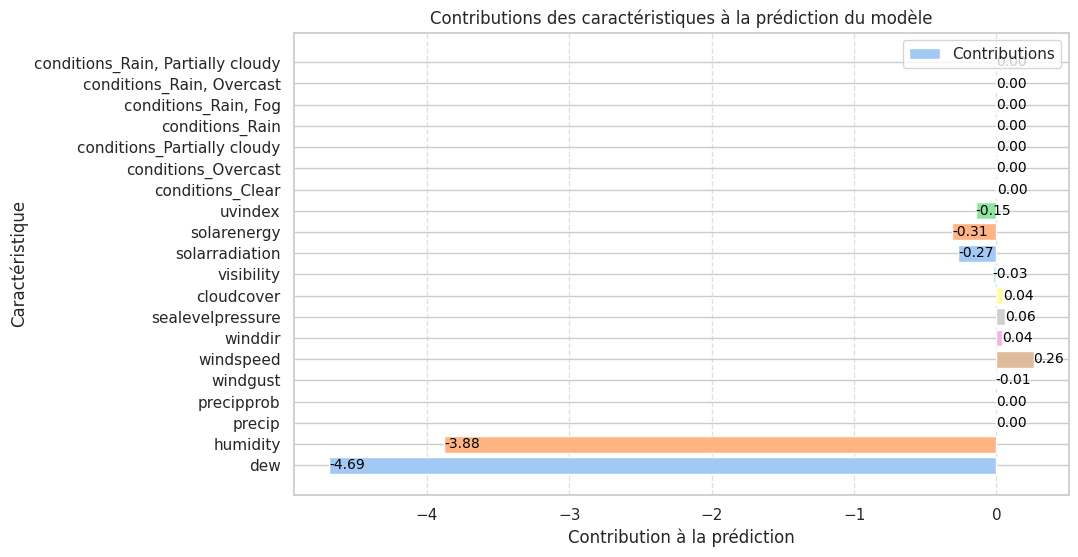

In [ ]:
# Personnalisez les paramètres du style de seaborn
sns.set(style="whitegrid")

# Créez une palette de couleurs personnalisée
colors = sns.color_palette("pastel")

# Affichez les contributions sous forme de graphique à barres
plt.figure(figsize=(10, 6))
bars = plt.barh(X_test.columns, contributions[0], color=colors)

# Ajoutez des étiquettes à chaque barre
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}',
             va='center', ha='left', fontsize=10, color='black')

# Personnalisez les étiquettes d'axe et le titre
plt.xlabel('Contribution à la prédiction')
plt.ylabel('Caractéristique')
plt.title('Contributions des caractéristiques à la prédiction du modèle')

# Affichez une légende (si nécessaire)
plt.legend(["Contributions"], loc='upper right')

# Affichez la grille en arrière-plan
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Affichez le graphique
plt.show()

<font size='4' face='MathJax_Math-italic'>

## **<font color='orange' > Interprétabilité Globale :</font>**


L'interprétabilité globale concerne la compréhension du modèle dans son ensemble, en examinant comment il prend des décisions sur l'ensemble des données d'entrée. Elle répond à la question : "Comment le modèle prend-il des décisions de manière générale ?"
Des techniques telles que l'importance des caractéristiques, les Partial Dependence Plots (PDP), les SHAP values avec l'interprétation globale, permettent d'analyser le modèle dans son intégralité. Ces méthodes offrent des informations sur la contribution relative de chaque caractéristique à l'ensemble du modèle, les relations entre les caractéristiques, et comment les prédictions varient avec différentes valeurs de caractéristiques.


## **<font color='navy' >Permutation importance</font>**


Cette technique évalue l'importance d'une caractéristique en permutant les valeurs de la caractéristique et en observant l'impact sur le score du modèle.

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance


# Initialisez la permutation importance1
perm_importance = PermutationImportance(best_et_regressor, random_state=42).fit(X_test, y_test)

# Affichez l'importance des caractéristiques
eli5.show_weights(perm_importance, feature_names=X_test.columns.tolist())

Weight,Feature
1.4081 ± 0.0154,dew
0.7111 ± 0.0125,humidity
0.0021 ± 0.0008,solarradiation
0.0010 ± 0.0008,windspeed
0.0008 ± 0.0010,sealevelpressure
0.0007 ± 0.0006,solarenergy
0.0006 ± 0.0009,uvindex
0.0006 ± 0.0003,conditions_Clear
0.0005 ± 0.0022,winddir
0.0004 ± 0.0002,cloudcover


<font size='4' face='MathJax_Math-italic'>


* **feelslike :** Cette caractéristique a le poids le plus élevé, indiquant qu'elle a une influence significative sur les prédictions du modèle. Cela suggère que la température ressentie est cruciale pour expliquer les variations dans la variable cible.

* **humidity :** Bien que le poids soit faible par rapport à feelslike, l'humidité semble avoir une certaine influence positive sur les prédictions. Cependant, l'impact est beaucoup moins important que celui de feelslike.

* **windspeed :** La vitesse du vent a également un poids positif, indiquant qu'elle contribue modestement aux prédictions.

* **Autres caractéristiques :** Les autres caractéristiques ont des poids nuls ou proches de zéro, suggérant qu'elles n'ont pas d'influence significative sur les prédictions du modèle. Ces caractéristiques peuvent être considérées comme ayant une importance limitée dans ce modèle particulier.


==> Selon la permutation importance, feelslike est la caractéristique la plus importante, suivie de l'humidité et de la vitesse du vent. Les autres caractéristiques semblent avoir une influence négligeable sur les prédictions du modèle.


<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >SHAP (SHapley Additive exPlanations) </font>**
SHAP (SHapley Additive exPlanations) est basé sur la théorie des jeux et les valeurs de Shapley, qui proviennent du domaine de la théorie des coalitions. Cette méthode offre des explications individualisées et cohérentes pour les prédictions de modèles, que ce soit à l'échelle globale ou locale.

### Interprétation Globale avec SHAP :

* **Valeurs de Shapley :**

SHAP attribue une valeur de Shapley à chaque caractéristique pour chaque prédiction. Ces valeurs représentent la contribution marginale moyenne d'une caractéristique à la prédiction sur toutes les permutations possibles des caractéristiques.

* **Valeurs Moyennes Globales :**

Les valeurs de Shapley individuelles sont ensuite agrégées pour obtenir des valeurs moyennes globales. Cela permet d'identifier l'impact moyen de chaque caractéristique sur les prédictions de l'ensemble du modèle.

* **Graphiques Sommaires :**

Les graphiques sommaires, tels que les "Summary Plots" de SHAP, affichent l'importance relative de chaque caractéristique pour l'ensemble du jeu de données. Ces graphiques sont utiles pour comprendre quelles caractéristiques ont le plus d'influence sur les prédictions du modèle.


In [ ]:
# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_train)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_train)

KeyboardInterrupt: 

In [ ]:
# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_test)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_test)

In [ ]:
# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_train)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_train)

In [ ]:
# Calculer les valeurs Shapley pour un échantillon de données
shap_values = explainer.shap_values(X_train)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
# Calculer les valeurs Shapley pour un échantillon de données
shap_values = explainer.shap_values(X_test)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# Calculer les valeurs Shapley pour un échantillon de données
shap_values = explainer.shap_values(X_val)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_val, plot_type="bar")

<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >Partial Dependence Plots (PDP)</font>**

La technique de l'interprétation d'arbre, souvent utilisée avec des modèles d'arbres de décision, permet de comprendre comment chaque caractéristique contribue à la prédiction globale du modèle. L'interprétation d'arbre peut être réalisée à l'aide de différentes méthodes, et l'une d'entre elles est l'utilisation d'un outil appelé "Tree Interpreter".

Voici une explication de la technique en utilisant Tree Interpreter :

Séparation des Caractéristiques : Dans un modèle d'arbre de décision, chaque nœud de l'arbre correspond à une décision basée sur une caractéristique spécifique. L'arbre est construit en séparant les données en fonction de ces caractéristiques.

Calcul des Contributions : L'interpréteur d'arbre calcule la contribution de chaque caractéristique à la prédiction globale du modèle. Pour chaque prédiction, il examine quelles caractéristiques ont été utilisées pendant le passage dans l'arbre et comment elles ont influencé la sortie.

Visualisation des Contributions : Les contributions calculées peuvent être visualisées sous forme de graphique à barres. Chaque barre représente la contribution d'une caractéristique spécifique à la prédiction. Une barre positive indique une contribution positive, tandis qu'une barre négative indique une contribution négative.

Compréhension Globale et Locale : L'interprétation d'arbre permet de comprendre l'impact global de chaque caractéristique sur les prédictions du modèle, ainsi que l'impact local pour des prédictions spécifiques.

Détection des Caractéristiques Importantes : En examinant les contributions, on peut identifier les caractéristiques qui ont le plus d'influence sur les prédictions du modèle. Cela peut aider à hiérarchiser l'importance des caractéristiques dans le processus de prise de décision du modèle.

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Ensemble pour suivre les variables déjà traitées
processed_variables = set()

# Parcourez toutes les variables de X_test
for feature_to_plot in X_test.columns:
    # Vérifiez si la variable est de type numérique et n'a pas été traitée
    if np.issubdtype(X_test[feature_to_plot].dtype, np.number) and feature_to_plot not in processed_variables:
        # Ajoutez la variable à l'ensemble des variables traitées
        processed_variables.add(feature_to_plot)

        # Calculer la dépendance partielle
        pdp, axes = partial_dependence(best_dt_regressor, X_test, features=[feature_to_plot])

        # Créer le display
        display = PartialDependenceDisplay.from_estimator(
            best_dt_regressor,
            X_test,
            features=[feature_to_plot],
        )

        # Personnaliser le graphique avec Matplotlib (facultatif)
        # Par exemple, ajoutez un titre au graphique
        display.plot()
        plt.title(f'Partial Dependence Plot for {feature_to_plot}')

        # Afficher le graphique avec Seaborn
        sns.despine()  # Facultatif : personnaliser l'apparence avec Seaborn
        plt.show()